# Interactively fit single correlator

Interactively fit a single 4pt function for fixed s and l

Nov 28, 2022

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import *
import glob 
import sys
import pickle 
import scipy.special as sc
# from scipy.special import logsumexp as sc.logsumexp

## Import fitting modules
import gvar as gv
import lsqfit


In [44]:
%matplotlib widget

## Modules

In [45]:
def f_plot_meff(t,y,max=200):
    '''
    t -> t values of correlator, y -> correlator gvar: val(err)
    max = max number of correlators to plot
    '''
    
    c=dict_global[str(s)]['c'] # Warning global dict_global and string s needed

    lst=[]

    n=(y[2:]+y[:-2])/(2.0*y[1:-1])
    m=np.arccosh(n) /c
#     print(m.shape)
    lst.append(np.nan)
    lst.extend(m)
    lst.append(np.nan)
    
    
    df1=pd.DataFrame(columns=['t','coeff','meff'])
    df1['t']=t
    df1['coeff']=y
    df1['meff']=np.array(lst)

    ## Plot effective mass
    plt.figure()
    df1=df1.dropna().head(max)
    val=df1.meff.values
    x,y,yerr=df1.t.values,[i.mean for i in val],[i.sdev for i in val]
    plt.errorbar(x,y,yerr,marker='o',linestyle='')
    
    plt.xlabel('t')
    plt.ylabel('Effective mass')
    

In [46]:
class corr:
    ''' Class to store correlators C(t) for specific l and s'''
    def __init__(self,df,l,c,s,Lt):
        self.df=df
        self.c=c
        self.s=s
        self.Lt=Lt
        self.l=l
        
        self.x_full=None
        self.y_full=None
        
        self.fit=None
        
    def f_perform_fit_exp(self,f_make_pars,func,fit_range,plt_range,num_exp=3,verbose=0,use_prior=False,plot=True):
              
        ## Define x and y for object for full plot range (Used only for fit)
        self.x_full={'t':self.df.t.values[min(plt_range):max(plt_range)+1],
                     'nterms':num_exp,'c':self.c,'Lt':self.Lt}
        self.y_full=self.df.coeff.values[min(plt_range):max(plt_range)+1]
        
        x=self.x_full.copy(); x['t']=x['t'][min(fit_range):max(fit_range)+1]
        y=self.y_full[min(fit_range):max(fit_range)+1]
        
        ### Create parameters dictionary: if prior gives gvars
        p0=f_make_pars(num_exp,self.l,use_prior)
        
        if use_prior:
            self.fit = lsqfit.nonlinear_fit(data=(x,y), prior=p0, fcn=func)
        else: 
            self.fit = lsqfit.nonlinear_fit(data=(x,y), p0=p0, fcn=func)

        ### Print fit details before plot
        if verbose==2: print(self.fit.format(maxline=True))
        elif verbose: print(self.fit.format(maxline=verbose))
        
        if plot: self.f_fit_plot(min(plt_range),max(plt_range),error_band=True,semilog=True)
        
        # Print description at the end
        if verbose:
            for k in self.fit.p.keys():
                if not use_prior:
                    print(k,'\tInit',self.fit.p0[k],'\t---Final',self.fit.p[k])
                else : 
                    print(k,'\tInit',self.fit.prior[k],'\t---Final',self.fit.p[k])    

            print("chi-sqr",self.fit.chi2/self.fit.dof)

        
    def f_fit_plot(self,start=0,end=None,error_band=True,semilog=True):
        '''
        Function for plotting data with the fit lines and error bands.
        For correlators, using a semi-log plot.
        full_data=True, plots the entire data and the best-fit in the fit region
        '''
        
        ## Create y_predictions for fit function
        x=self.x_full; y=self.y_full
        curve_t={}
        curve_x=self.x_full.copy()
        curve_t['t']=np.linspace(min(x['t']),max(x['t']),500)
        curve_x['t']=curve_t['t']; ## Modify curve_x['ts'] to the range required
        
        curve_y=self.fit.fcn(curve_x,self.fit.p)
        obs_fit=gv.mean(curve_y)
        err_fit=gv.sdev(curve_y)
        sigma=2.0 # Width for band

        #### Plots
        fig=plt.figure()
          
        # Plot all data points
        x=self.x_full; y=self.y_full
        plt.errorbar(x['t'],y=gv.mean(y),yerr=gv.sdev(y),linestyle='None',color='black',marker='*',markersize=4)

        # Plot the best fit line
        plt.plot(curve_t['t'],obs_fit,color='blue')

        if error_band: # Plot an error band around the best fit line
            plt.fill_between(curve_t['t'],obs_fit-sigma*err_fit,obs_fit+sigma*err_fit,color='yellow')

        ## Plot data points used in fit with different color
        x=self.fit.x; y=self.fit.y
        plt.errorbar(x['t'],y=gv.mean(y),yerr=gv.sdev(y),linestyle='None',color='red',marker='H',markersize=5)    
        
        if semilog: plt.yscale('log')
        plt.ylabel('C(t)')
        plt.xlabel('t')
        plt.title("Plot")
        plt.show()
        

### Fit functions

In [47]:
def f_multi_exp(x,p):
    
    t=x['t']
    num_exp=x['nterms']
    c=x['c']
    Lt=x['Lt']
    
#     g=np.sqrt(8*np.pi/(3**(0.5)*Nsites))
    g=1.0
    
    ans=0.0
    ans=p['const']
    for i in range(num_exp):
        ans+= p["a{}".format(i)]*np.exp(-p["E{}".format(i)]* g * c *t)
    
    return ans


def f_multi_exp2(x,p):
    
    t=x['t']
    num_exp=x['nterms']
    c=x['c']
    Lt=x['Lt']
#     g=np.sqrt(8*np.pi/(3**(0.5)*Nsites))
    g=1
    
#     ans=0.0
    ans=p['const']
    for i in range(num_exp):
        ans+= p["a{}".format(i)]*np.exp(-p["E{}".format(i)]* g * c * t)
        ans+= p["a{}".format(i)]*np.exp(-p["E{}".format(i)]* g * c * (Lt-t))
    
    return ans

def f_cosh(x,p):

    t=x['t']
    num_exp=x['nterms']
    c=x['c']
    Lt=x['Lt']
    g=1

    ans=0.0
    ans=p['const']
    for i in range(num_exp):
        ans+= p["a{}".format(i)]*np.cosh(p["E{}".format(i)]* g * c * (Lt/2-t))

    return ans

In [48]:
def f_make_pars(num_exp,l,use_prior):
    
    par_dict={}
    par_dict = gv.BufferDict()         # any dictionary works

    if l==0: 
        vals_a=[1,1,1,1]; vals_e=[1,3,5,7]
    elif l==2: 
        vals_a=[1,1,1,1]; vals_e=[2,3,5,7] # 2 is Wrap around term
    elif l==4: 
        vals_a=[1e-3,1,1,1]; vals_e=[3,5,7,9] # 3 is SB term
    elif l==6: 
        vals_a=[1e-5,1,1e-5,1,1]; vals_e=[1,7,3,9,11] # 1 is SB term
    else: 
        raise SystemError
    w_factor = 0.3 # fraction of uncertainty for prior
    
    keys_a=["a{0}".format(i) for i in range(num_exp)]
    keys_e=["E{0}".format(i) for i in range(num_exp)]
    
    for i in range(num_exp): 
        if use_prior: 
            par_dict[keys_a[i]]=gv.gvar(vals_a[i],vals_a[i]*w_factor)
            par_dict[keys_e[i]]=gv.gvar(vals_e[i],vals_e[i]*w_factor)
        else : 
            par_dict[keys_a[i]]=vals_a[i]
            par_dict[keys_e[i]]=vals_e[i]
                    
    par_dict['const']=1.0 # No constant term for 2pt function
    
    return par_dict

In [49]:
def f_scale_4pt(row,s):
    a1=row['coeff']/(dict_global[str(s)]['2pt']**2) # divide by phi_2pt ^ 2 
    return a1

def f_get_data_df(fname):

    arr=np.loadtxt(fname)
    
    ## Extract values from file name
    s=int(fname.split('/')[-1].split('_')[2].split('k')[-1].split('t')[0])
    Lt=int(fname.split('/')[-1].split('_')[2].split('k')[-1].split('t')[-1])
    
    print(s,Lt)
    Nsites=10*(s**2)+2
    # c=dict_global[str(s)]['c']

    ### Gather data from file
    cols=['l','t','coeff']
    df_data=pd.DataFrame(arr,columns=cols)

    ### Process data
    # df_data.apply(lambda row: f_scale_4pt(row,s),axis=1)
    df_data['coeff']=df_data.apply(lambda row: f_scale_4pt(row,s),axis=1)
    df_data.loc[df_data.l==0,['coeff']]-=1 ## subtract out the 1 for l=0
    
    # df_data['coeff']=np.array([gv.gvar(i,i*0.01) for i in df_data.coeff.values])
    df_data['coeff']=np.array([gv.gvar(i,max(i*1e-4,1e-13)) for i in df_data.coeff.values]) # Ensure error doesn't go below machine precision
    

    return df_data,Lt


## Load global data

In [50]:
dict_global={}
data_dict={}
dict_global['4']=  {'2pt':1.126500594310e-02, 'c':2.758810226094e-01}
dict_global['8']=  {'2pt':5.591911340388e-03, 'c':1.395714549742e-01}
dict_global['16']= {'2pt':2.790831203460e-03, 'c':6.999296068404e-02}
dict_global

{'4': {'2pt': 0.0112650059431, 'c': 0.2758810226094},
 '8': {'2pt': 0.005591911340388, 'c': 0.1395714549742},
 '16': {'2pt': 0.00279083120346, 'c': 0.06999296068404}}

## Read data from files

In [51]:
data_dir='../data/free_theory/'

s_list=[4,8,16]
for s in s_list:
    # print(data_dir+'s2xr_free_q5k{0}t*_4pt_pl.dat'.format(s))
    fname=glob.glob(data_dir+'s2xr_free_q5k{0}t*_4pt_pl.dat'.format(s))[0]
    print(fname,s)
    df,Lt=f_get_data_df(fname)
    data_dict[str(s)]={'df':df,'Lt':Lt}

../data/free_theory/s2xr_free_q5k4t64_4pt_pl.dat 4
4 64
../data/free_theory/s2xr_free_q5k8t128_4pt_pl.dat 8
8 128
../data/free_theory/s2xr_free_q5k16t256_4pt_pl.dat 16
16 256


$$ \frac{\langle \phi_4 \rangle }{ \langle \phi_2^2 \rangle} = \sum_{l,\Delta} A_{l,\Delta} \cosh\left[c \ (\Delta + l ) (t-T/2) \right] $$

## Interactive fits

In [59]:
## Pick a specific correlator for fixed 's' and 'l'
s='16';l=0
df_temp=data_dict[s]['df']
Lt=data_dict[s]['Lt']
df_temp=df_temp[df_temp.l==l][['t','coeff']]

In [60]:
df_temp

,t,coeff
0,0.0,22.3619(22)
1,1.0,13.4042(13)
2,2.0,10.6221(11)
3,3.0,9.01192(90)
4,4.0,7.87578(79)
...,...,...
124,124.0,0.00418917(42)
125,125.0,0.00415359(42)
126,126.0,0.00412830(41)
127,127.0,0.00411318(41)


### Plot correlator and effective mass

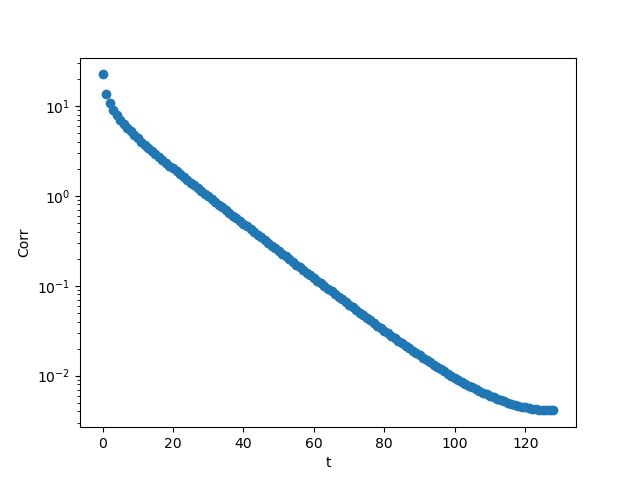

Text(0.5, 1.0, 'Effective mass')

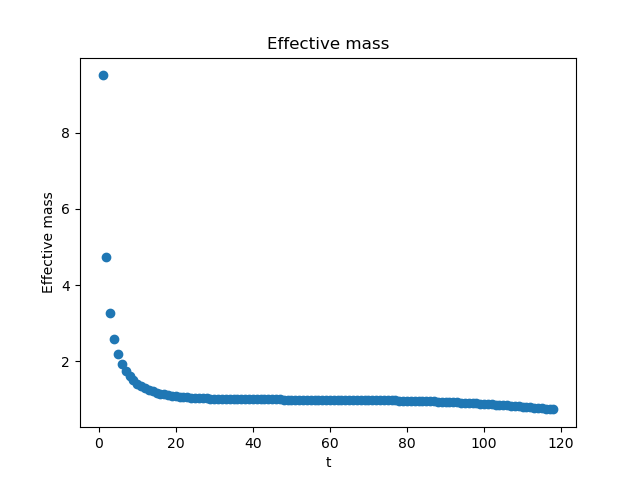

In [61]:
plt.figure()
x=df_temp.t.values
y=[i.mean for i in df_temp.coeff.values]
yerr=[i.sdev for i in df_temp.coeff.values]

plt.errorbar(x,y,yerr,marker='o',linestyle='')
plt.ylabel('Corr')
plt.xlabel('t')
plt.yscale('log')
plt.show()

## Effective mass
f_plot_meff(df_temp.t.values[:120],df_temp.coeff.values[:120],120)
plt.title("Effective mass")

### Widget

In [62]:
Corr=corr(df=df_temp,l=l,c=dict_global[str(s)]['c'],s=s,Lt=Lt)

In [63]:
tmax=int(np.max(df_temp.t.values)) # Max value of t obtained from dataframe

func_w=Dropdown(options=[f_multi_exp,f_multi_exp2,f_cosh],value=f_multi_exp2,description='fit func',disabled=False)
tr=IntRangeSlider(value=[20,tmax],min=0,max=tmax,step=1,description='trange')
pr=IntRangeSlider(value=[0,tmax],min=0,max=tmax,step=1,description='plot range')
# pr_w=widgets.Checkbox(value=False,description='use_prior',indent=False,disabled=False)
plt_w=Checkbox(value=True,description='plot',indent=False,disabled=False)
numexp_w=IntSlider(value=2,min=1,max=8,step=1,description='num_exp')
verbose_w=IntSlider(value=1,min=-1,max=2,step=1,description='verbose_w')

# (self,f_make_pars,func,fit_range,plt_range,num_exp=3,verbose=0,use_prior=False,plot=True)

v1=VBox([tr,pr])
v2=VBox([numexp_w,verbose_w])
v3=VBox([plt_w])

ui=HBox(children=[v1,func_w,v2,v3])
        
out=interactive_output(Corr.f_perform_fit_exp, {'f_make_pars':fixed(f_make_pars),
         'func':func_w,'fit_range':tr, 'plt_range':pr,'num_exp':numexp_w, 
         'verbose':verbose_w,'use_prior':fixed(False),'plot':plt_w})

display(out,ui)

Output()

In [42]:
# Corr.f_perform_fit_exp(f_make_pars,f_multi_exp2,np.arange(6,24),[0,32],1,0,False,True) # l=0,1,2,3